In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import glob
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
import re
import seaborn as sns
from math import radians, sin, cos, asin, sqrt
import imageio
import os
from IPython.display import Image, display
import time
from scipy.stats import gaussian_kde
from statistics import mean
import statistics
import random
import spacetrees

In [12]:
plotdir = 'plots/'
datadir = 'data/'

# load data

## parameters

In [13]:
M = 100 #number of importance samples
CHR = 18 
T = 'None'
samples = range(278*2)

## estimated dispersal rate

In [14]:
prefix = 'SGDP_v1_annot_ne'
dispersal = np.loadtxt(datadir + prefix + '_%dM_%sT.sigma' %(M, T), delimiter=',')
sigma = spacetrees._params_to_sigma(dispersal[:-1])
sigma

array([[ 1.87559830e-04, -4.08668660e-05,  7.33994918e-06],
       [-4.08668660e-05,  2.13833710e-04, -3.35536375e-06],
       [ 7.33994918e-06, -3.35536375e-06,  9.76974316e-05]])

## estimated ancestor locations

In [15]:
ancestor_times = np.logspace(np.log10(4),np.log10(40000),20)
ancestor_loci = [i*1000+1 for i in range(42)]

In [16]:
s = 'All'
t = 'All'
# load locations
anc_locs = []
for locus in ancestor_loci:
    anc_loc = np.loadtxt(datadir + prefix + '_chr%d_%dlocus_%dM_%sT_%ss_%st.locs' %(CHR,locus,M,T,s,t), delimiter=',')
    anc_locs.append(anc_loc)
anc_locs = np.array(anc_locs)
# anc_locs = np.swapaxes(anc_locs,0,1)
anc_locs.shape

(42, 11120, 5)

In [17]:
# convert back to longlat
# https://github.com/awohns/unified_genealogy_paper/blob/master/src/utility.py
def polar_to_longlat(x,y,z):
    long = np.arctan2(y, x)
    square = np.sqrt(x**2 + y**2)
    lat = np.arctan2(z, square)
    return np.degrees(long), np.degrees(lat)

In [18]:
def longlat_to_polar(long,lat):
    lat_radians = np.radians(lat)
    long_radians = np.radians(long)
    x = np.cos(lat_radians) * np.cos(long_radians)
    y = np.cos(lat_radians) * np.sin(long_radians)
    z = np.sin(lat_radians)
    return x,y,z

In [19]:
longlatss = []
for locus in anc_locs:
    longlats = []
    for row in locus:
        long,lat = polar_to_longlat(row[2],row[3],row[4])
        newrow = np.append(row,[long,lat])
        longlats.append(newrow)
    longlatss.append(longlats)
anc_locs = np.array(longlatss)

In [20]:
L,n,d = anc_locs.shape
anc_locs = anc_locs.reshape(L,len(samples),len(ancestor_times),d)
anc_locs.shape

(42, 556, 20, 7)

# comparison with Wohns et al 2022

## fig 4b

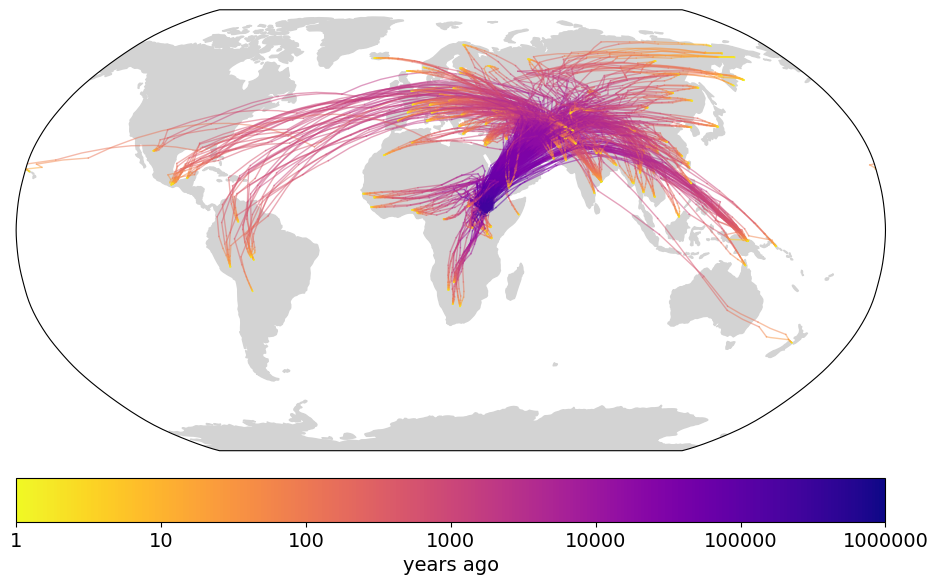

In [21]:
fig = plt.figure(figsize=(10, 6), dpi=100, edgecolor='k')
projection = ccrs.Robinson(central_longitude=20)
data_crs = ccrs.PlateCarree() #data supplied in lat/long
geodetic = ccrs.Geodetic() #for great circles
ax = plt.axes(projection=projection)
ax.set_global()
ax.add_feature(cfeature.LAND, color='lightgray')
cmap = plt.get_cmap("plasma_r")

for sample in samples: #samples: #for each sample

    # get mean ancestor location at all times
    mean_locs = []
    # time_loc = locations[sample] #start with sample location
    for time_ix in range(len(ancestor_times)): #exclude late times as numerical issues
        locs = anc_locs[:,sample,time_ix,-2:] #locations of all ancestors
        mean_loc = np.mean(locs, axis=0) #mean ancestor location       
        mean_locs.append(mean_loc)
    mean_locs = np.array(mean_locs)

    # plot trajectory of mean ancestor colored by time
    for i in range(len(mean_locs) - 1):
        color = cmap(i / len(mean_locs))
        x0,y0 = mean_locs[i, 0], mean_locs[i, 1]
        x1,y1 = mean_locs[i+1, 0], mean_locs[i+1, 1]
        ax.plot([x0,x1], [y0,y1], color=color, lw=1, alpha=0.5, transform=geodetic) #great circles
        # ax.plot([x0,x1], [y0,y1], color=color, lw=1, alpha=0.5, transform=data_crs) #straight lines

cbar = fig.colorbar(plt.cm.ScalarMappable(norm=None, cmap=cmap), ax=ax, orientation='horizontal', pad=0.05, shrink=0.9)
# cbar.set_ticks([i/4 for i in range(5)])
# cbar.set_ticklabels(np.round(np.logspace(1,np.log10(ancestor_times[time_ix]),5)*25).astype(int).tolist())
ts = [10**i for i in range(7)]
cbar.set_ticks(np.log10(ts)/np.log10(ancestor_times[time_ix]*25)) #gen time = 25 years
cbar.set_ticklabels(ts)
cbar.set_label(('years ago'), fontsize=14)
cbar.ax.tick_params(labelsize=14)

plt.tight_layout()
plt.savefig(plotdir + 'wohns_4b.png')
plt.show()

## fig 4c

In [26]:
[int(i)*25 for i in ancestor_times]

[100,
 150,
 250,
 425,
 675,
 1125,
 1825,
 2975,
 4825,
 7825,
 12725,
 20675,
 33575,
 54550,
 88575,
 143825,
 233550,
 379250,
 615825,
 1000000]

In [32]:
ancestor_times[7]*25
ancestor_times[11]*25
ancestor_times[13]*25
ancestor_times[15]*25
ancestor_times[16]*25
ancestor_times[18]*25

np.float64(615848.2110660255)

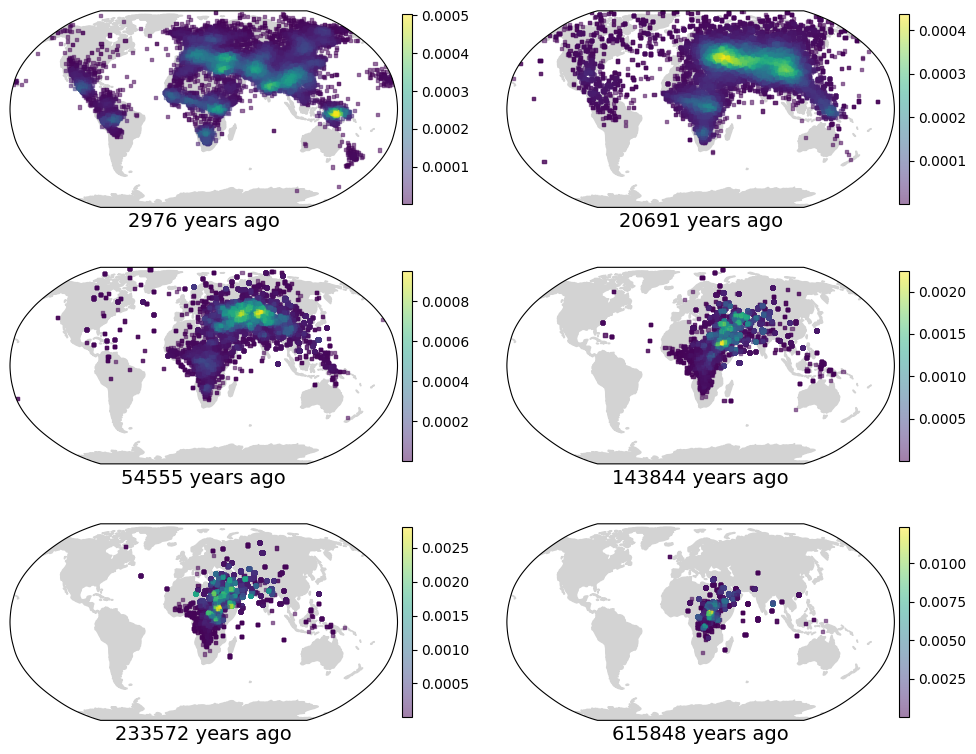

In [33]:
projection = ccrs.Robinson(central_longitude=20)
fig,axs = plt.subplots(3,2, subplot_kw={'projection': projection}, figsize=(10,8))
data_crs = ccrs.PlateCarree() #data supplied in lat/long

axs = axs.flatten()

for i,time_ix in enumerate([7,11,13,15,16,18]):

    # ax = axs[i] = plt.axes(projection=projection)
    axs[i].set_global()
    axs[i].add_feature(cfeature.LAND, color='lightgray')
    
    # all ancestors at given time
    all_locs = []
    for sample in range(len(samples)):
        locs = anc_locs[:, sample, time_ix, -2:]
        all_locs.append(locs)
    all_locs = np.vstack(all_locs)
    
    # estimate density
    xy = np.vstack([all_locs[:, 0], all_locs[:, 1]])
    kde = gaussian_kde(xy, bw_method=0.1) 
    z = kde(xy)

    # plot density
    sc = axs[i].scatter(all_locs[:, 0], all_locs[:, 1], c=z, s=5, marker='s', cmap='viridis', alpha=0.5, zorder=0, transform=data_crs)

    # color bar
    cbar = plt.colorbar(sc, orientation='vertical', pad=0.01, shrink=0.75, ax=axs[i])

    # # text
    axs[i].text(0.5, -0.1, '%d years ago' % int(ancestor_times[time_ix]*25), ha='center', fontsize=14, transform=axs[i].transAxes)

plt.tight_layout()
plt.savefig(plotdir + 'wohns_4c.png')
plt.show()

## supplementary video

In [34]:
# defining groups

# get group of each genome
ids = []
groups = []
with open('data/SGDP.poplabels',"rb") as f:
    next(f) #skip header
    for line in f:
        ids.append(line.strip().split(b' ')[0])
        groups.append(line.strip().split(b' ')[2])
    groups = [entry.decode('utf-8') for entry in groups]
    groups = [item for item in groups for _ in range(2)] #repeat for each genome in diploid
group_names, group_ixs = np.unique(groups, return_inverse=True)

# give each group a color
group_colors = ['yellow','red','pink','green','brown','purple','lightblue']

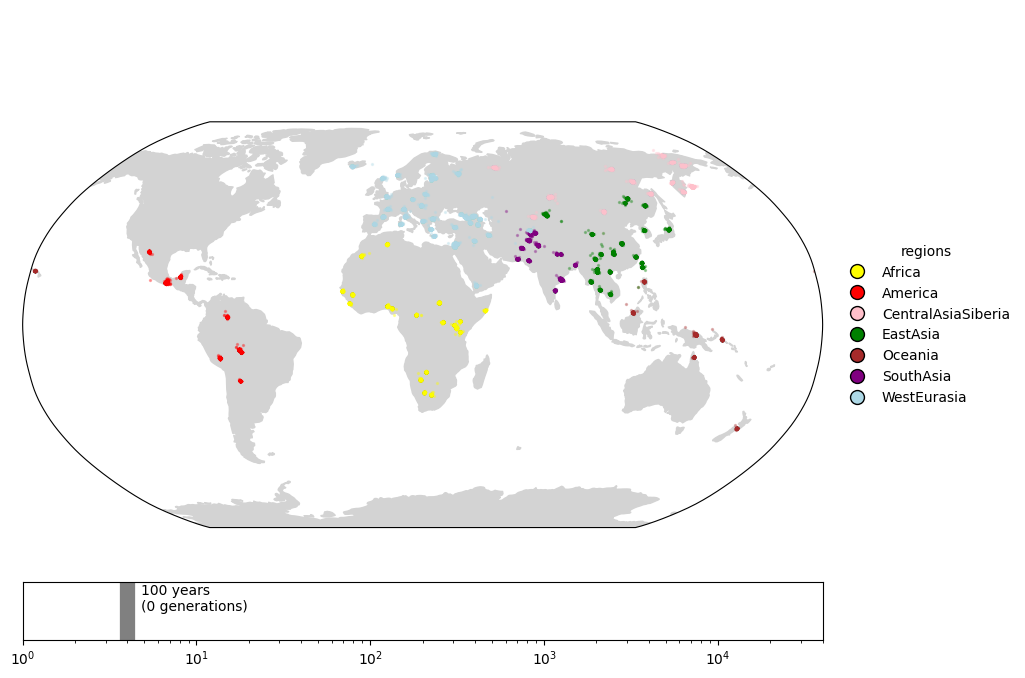

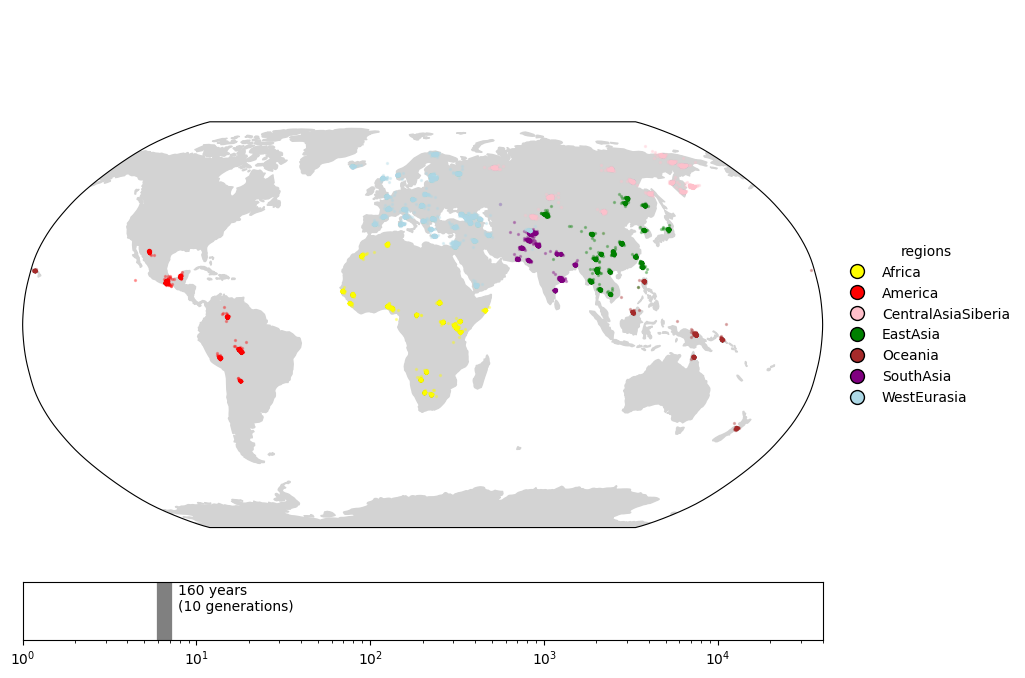

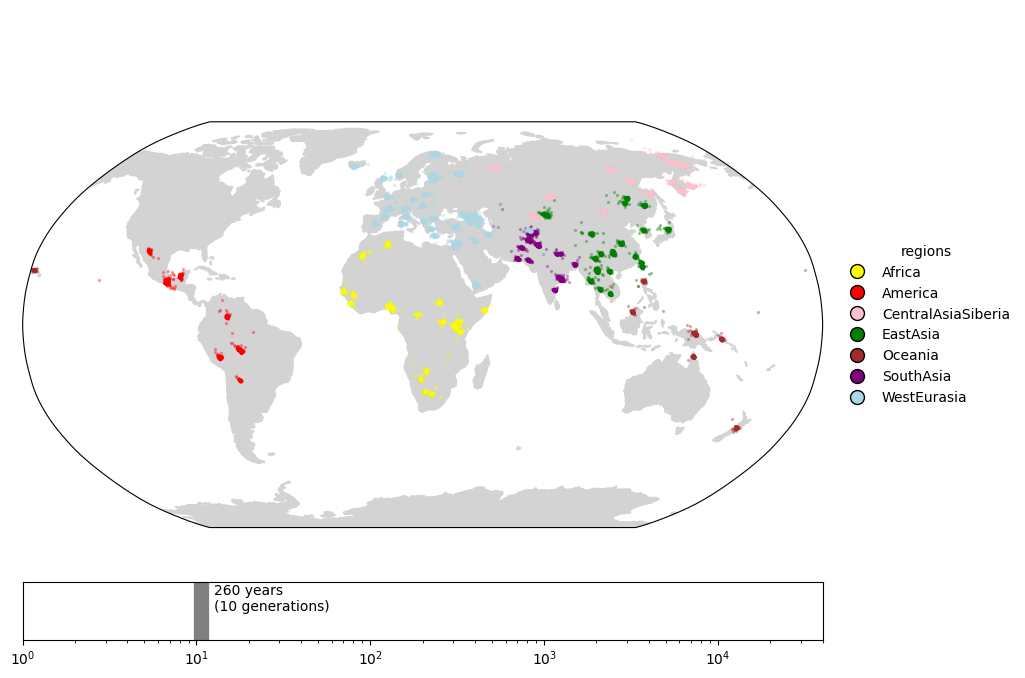

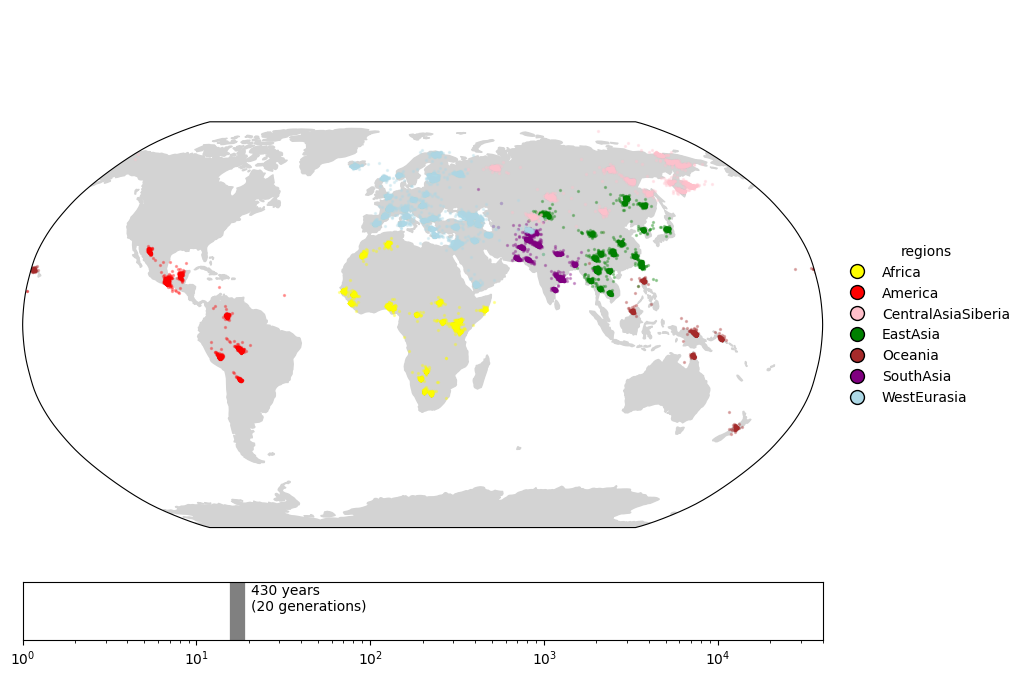

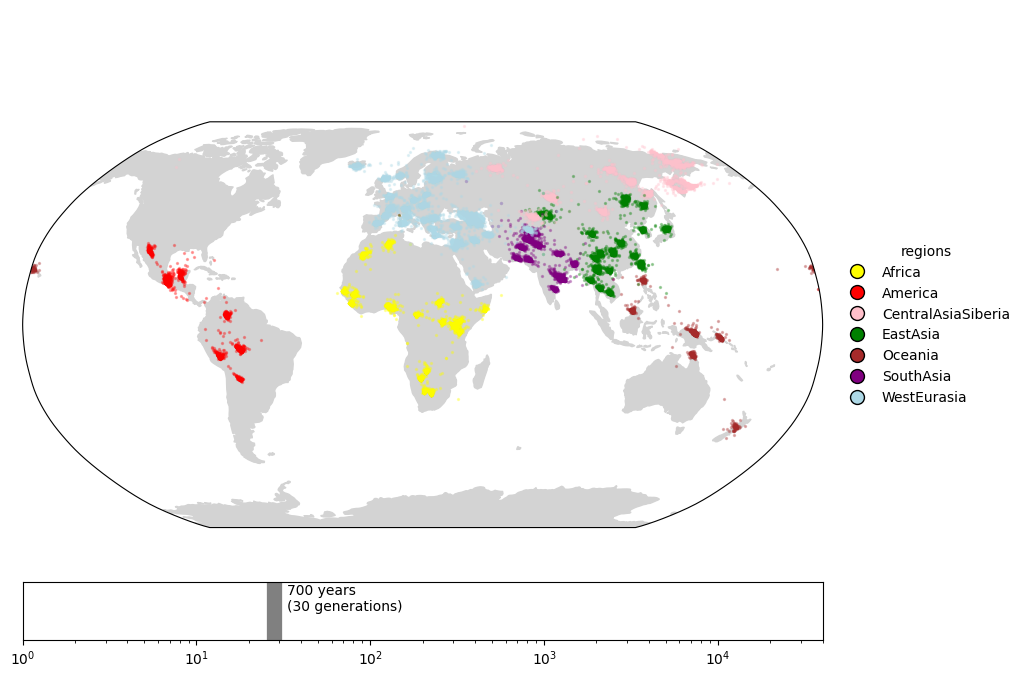

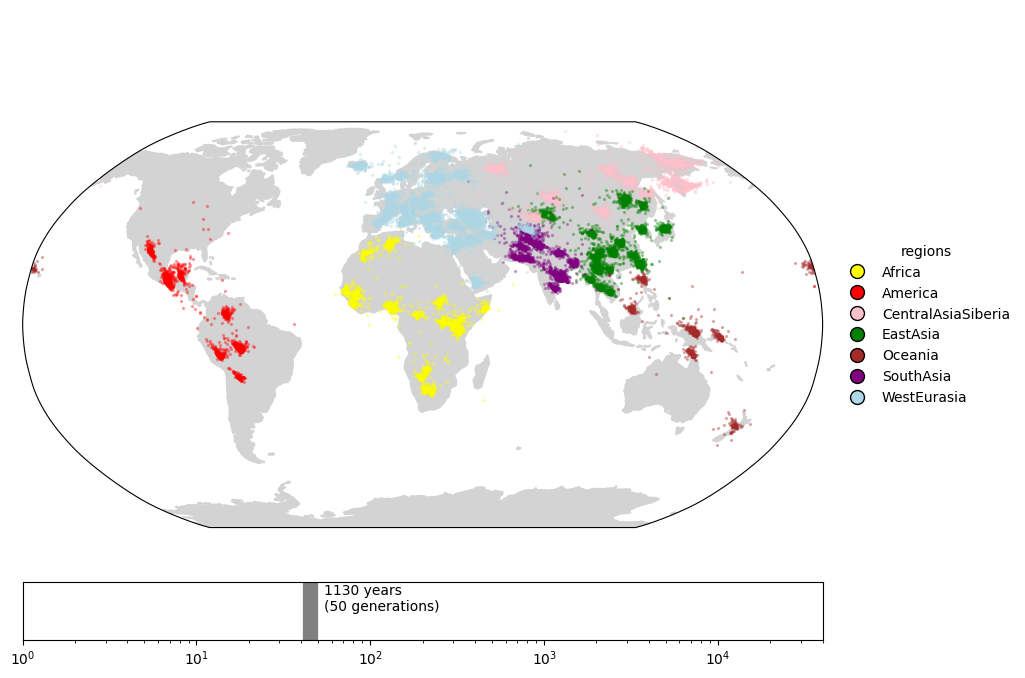

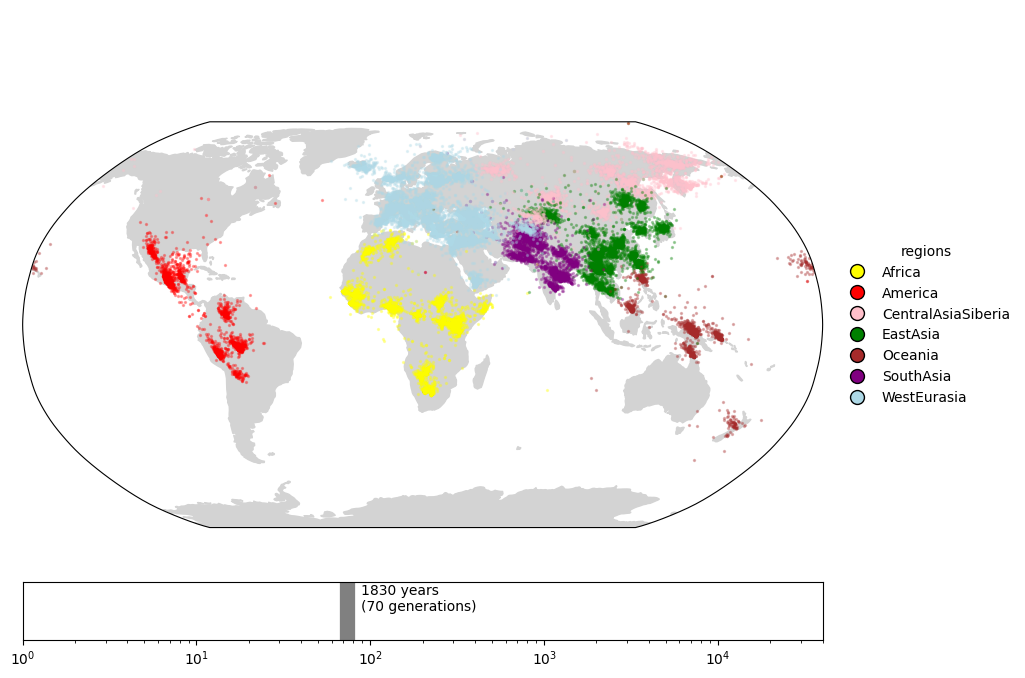

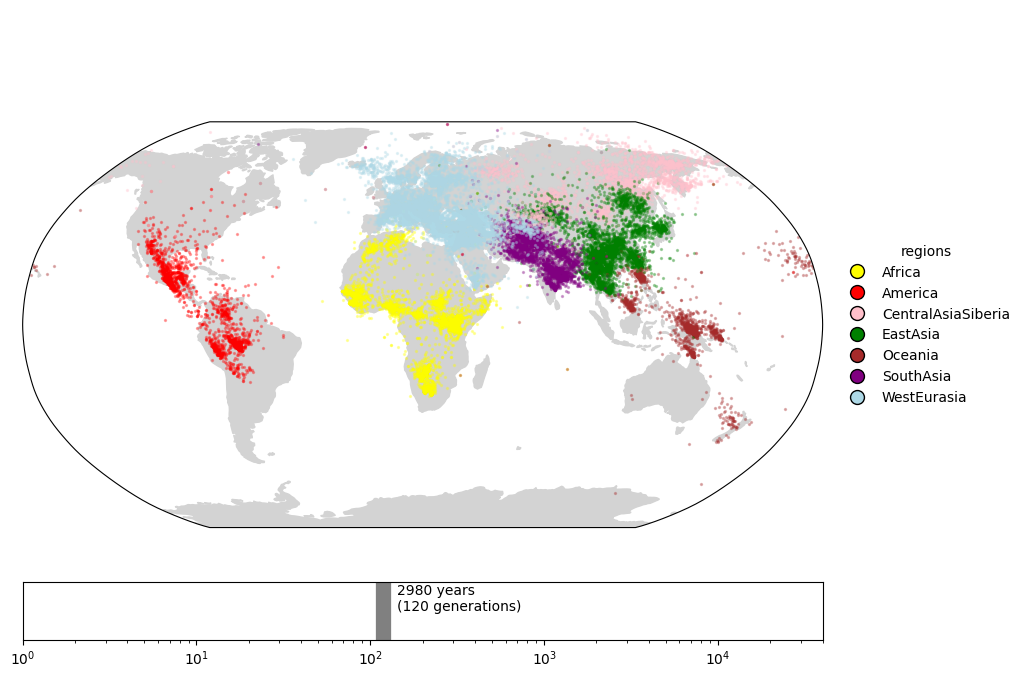

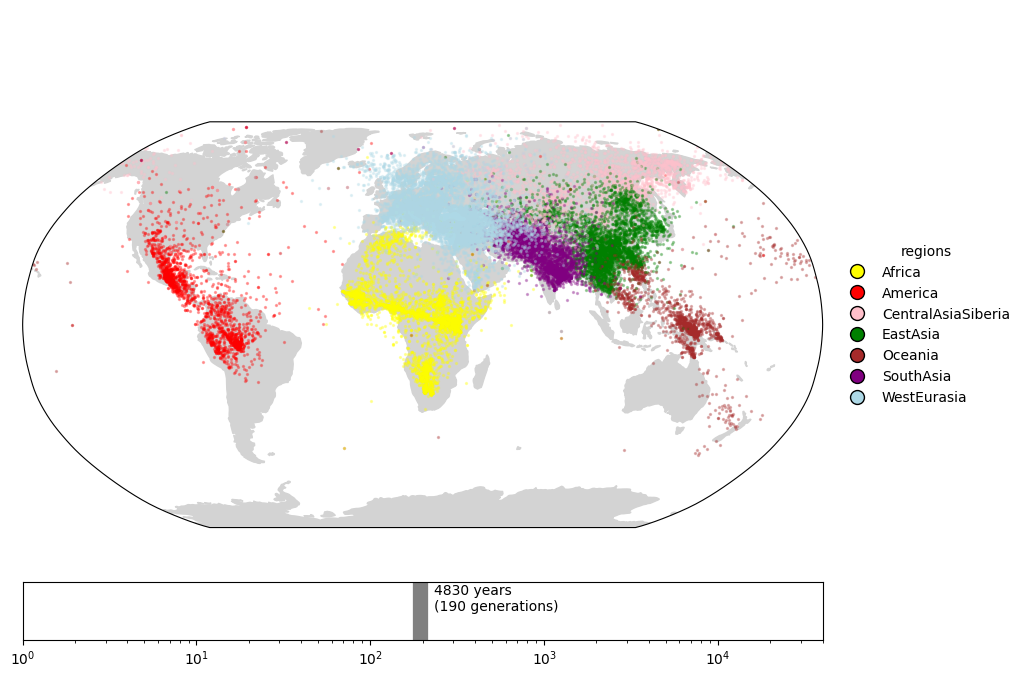

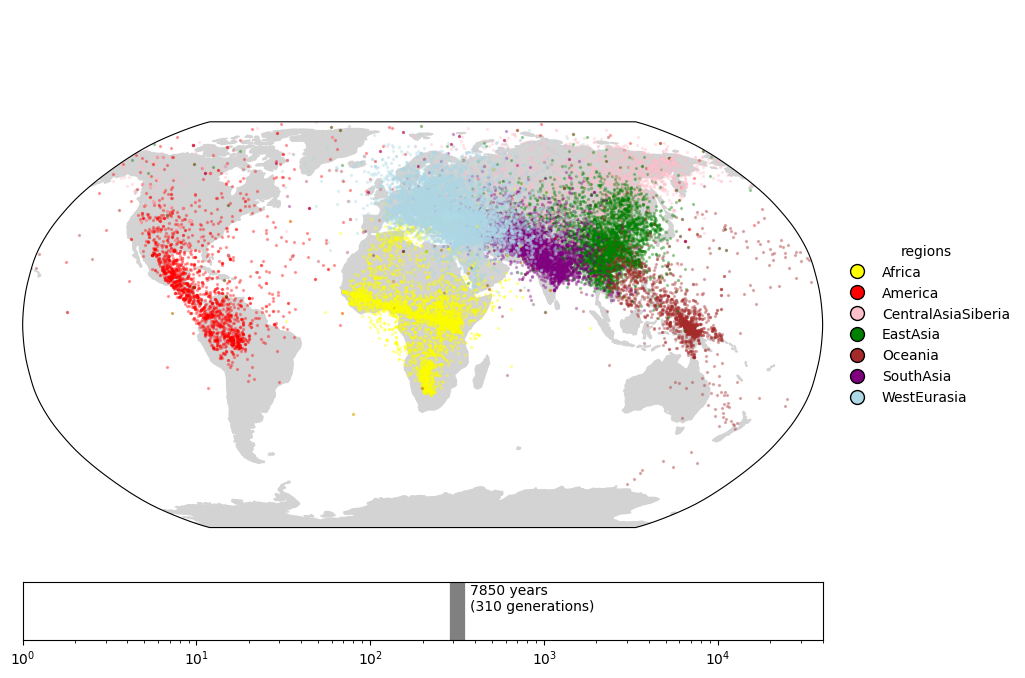

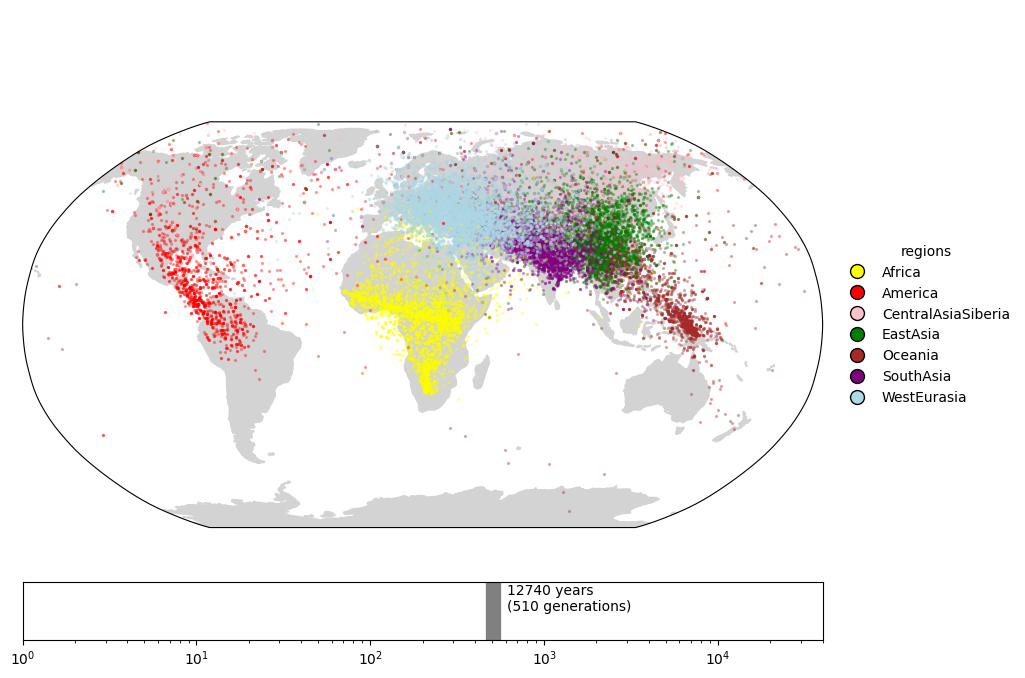

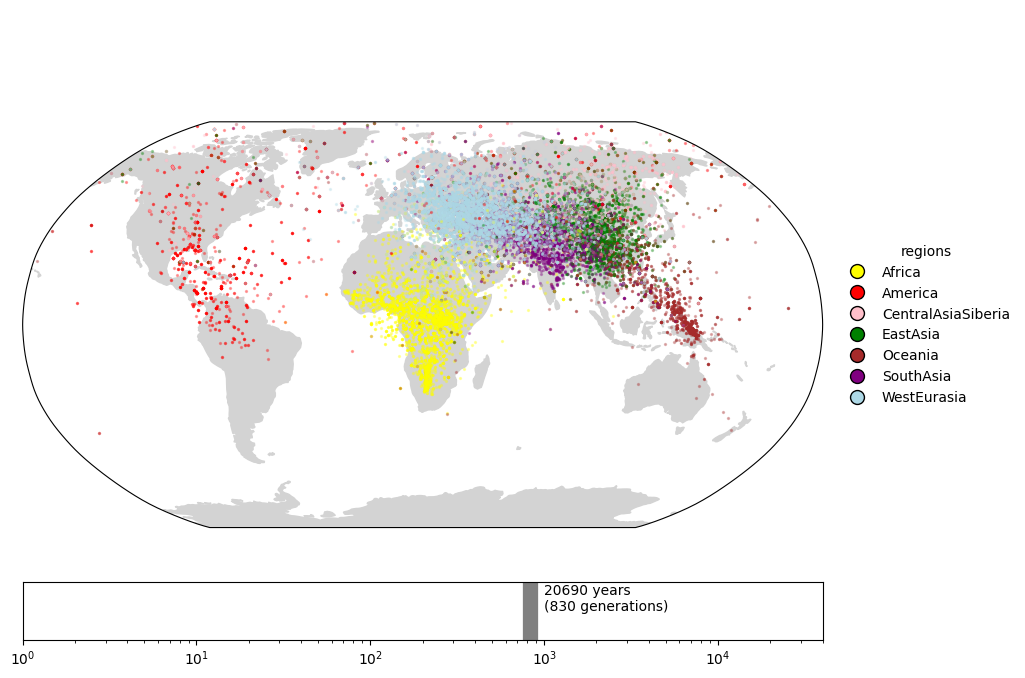

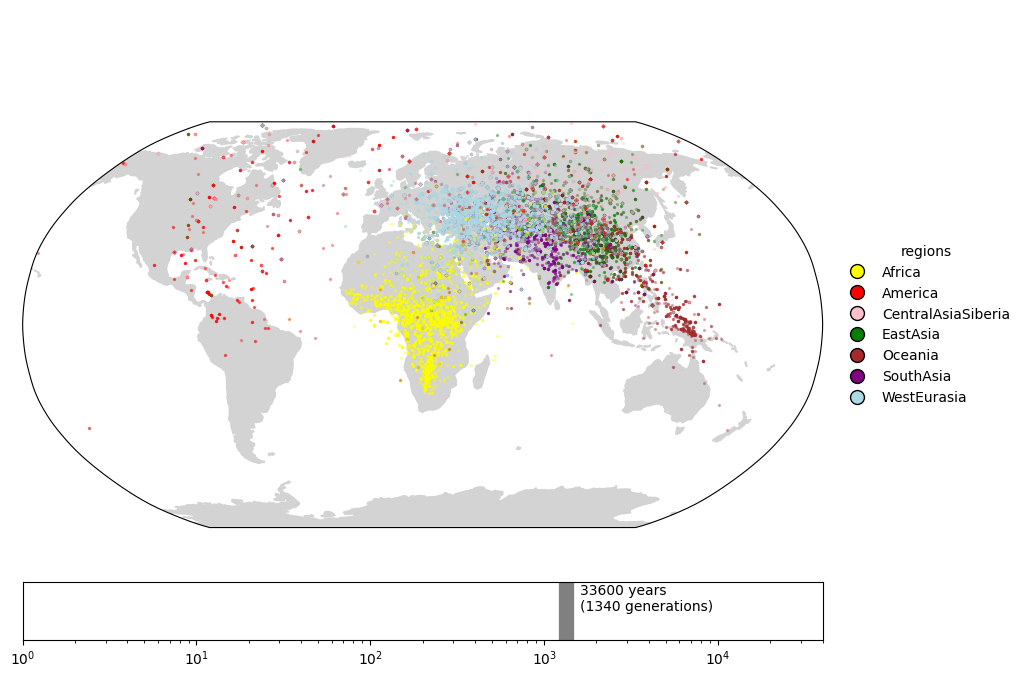

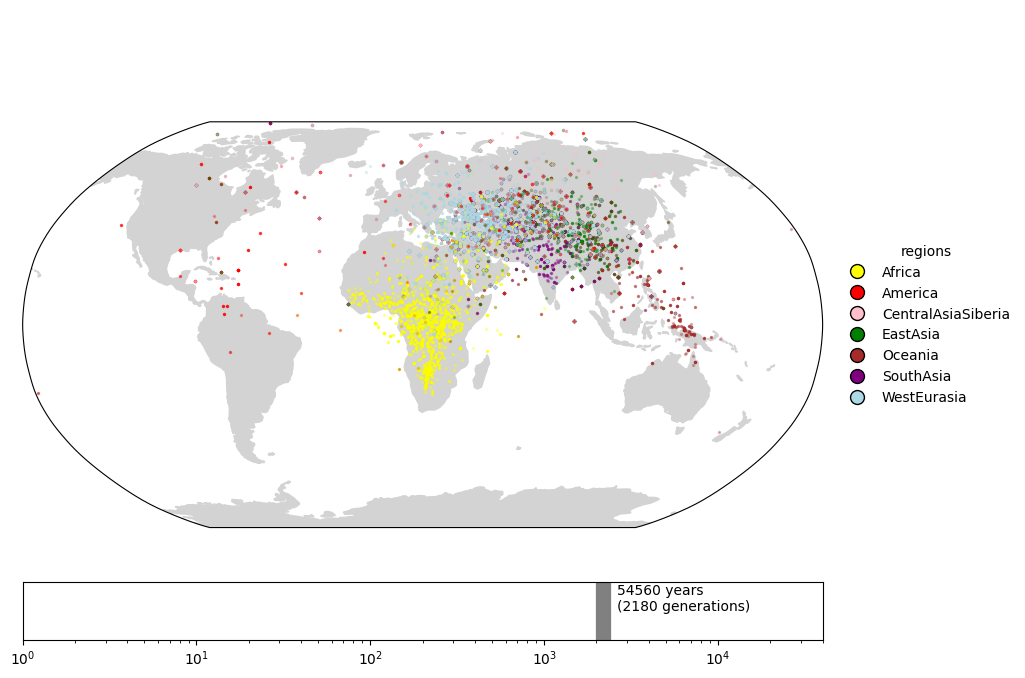

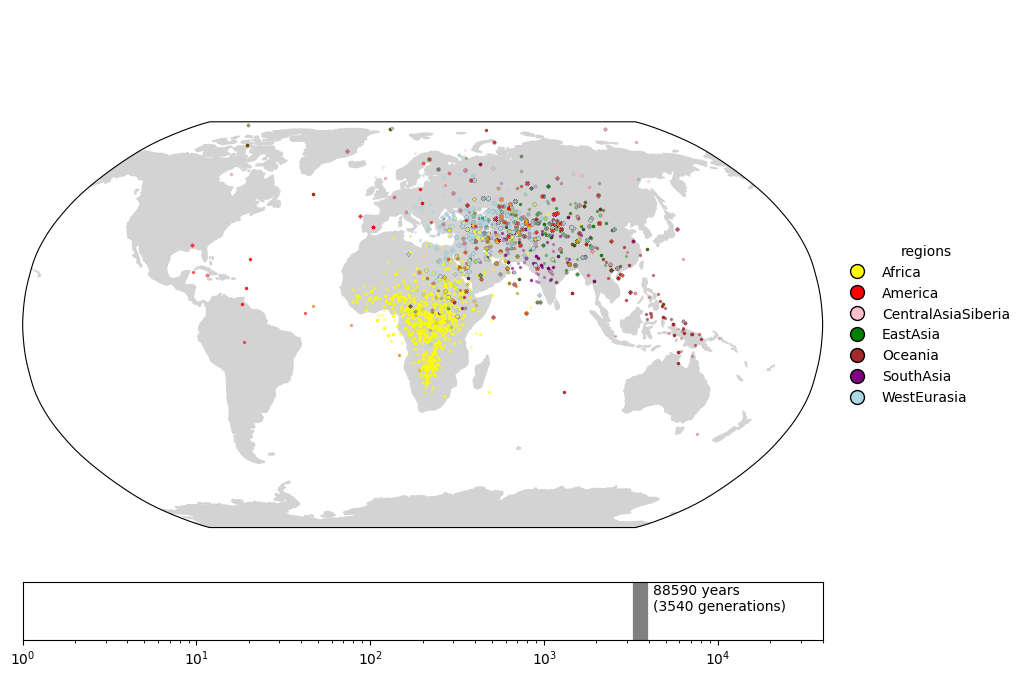

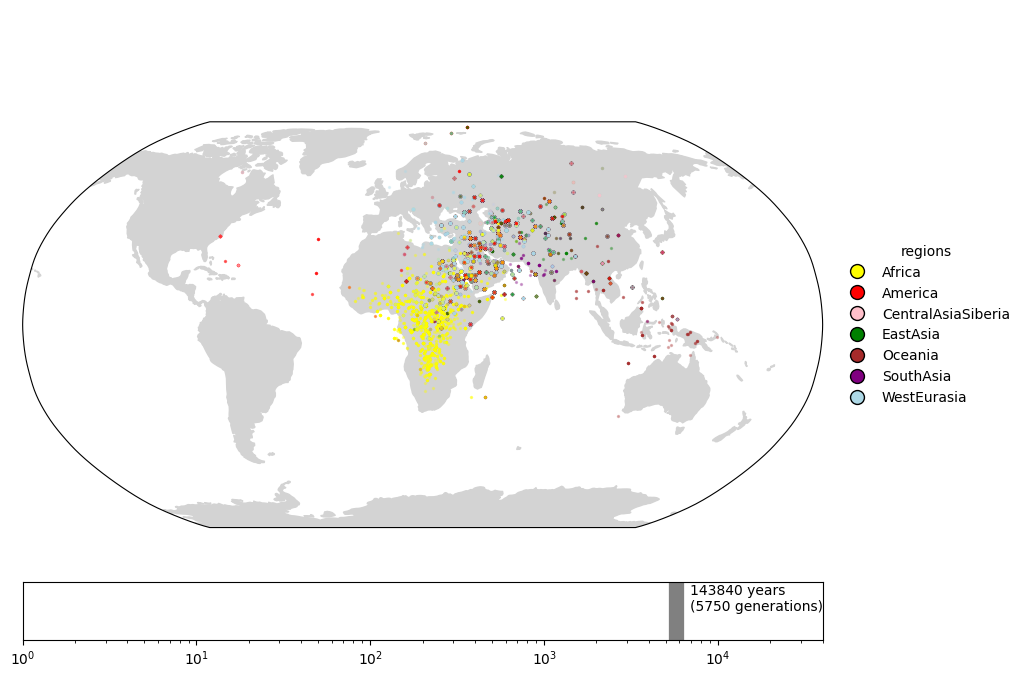

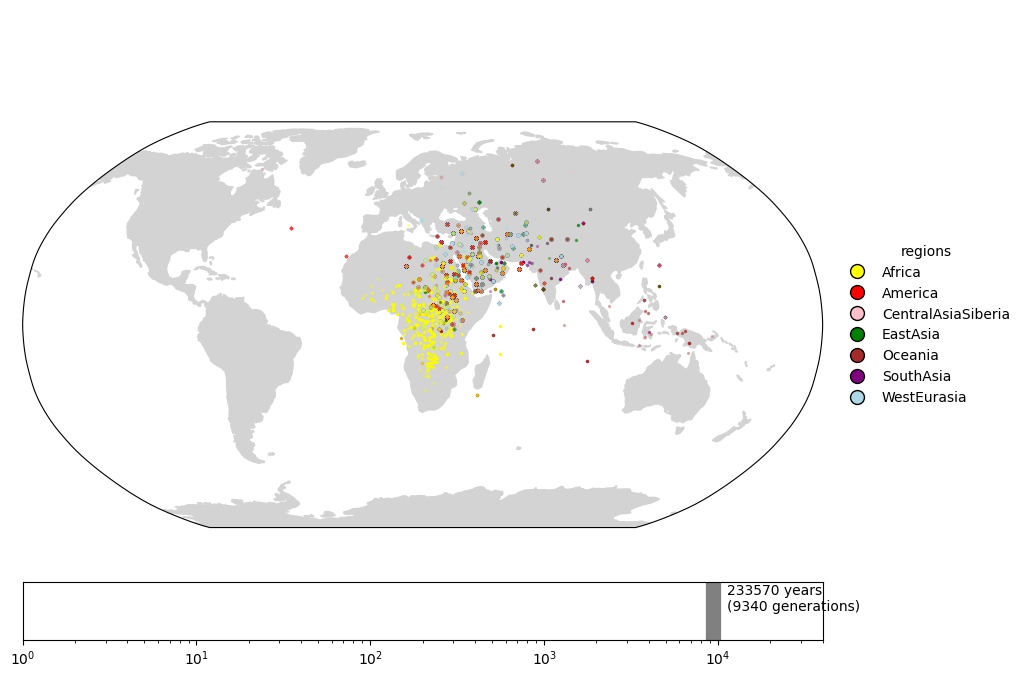

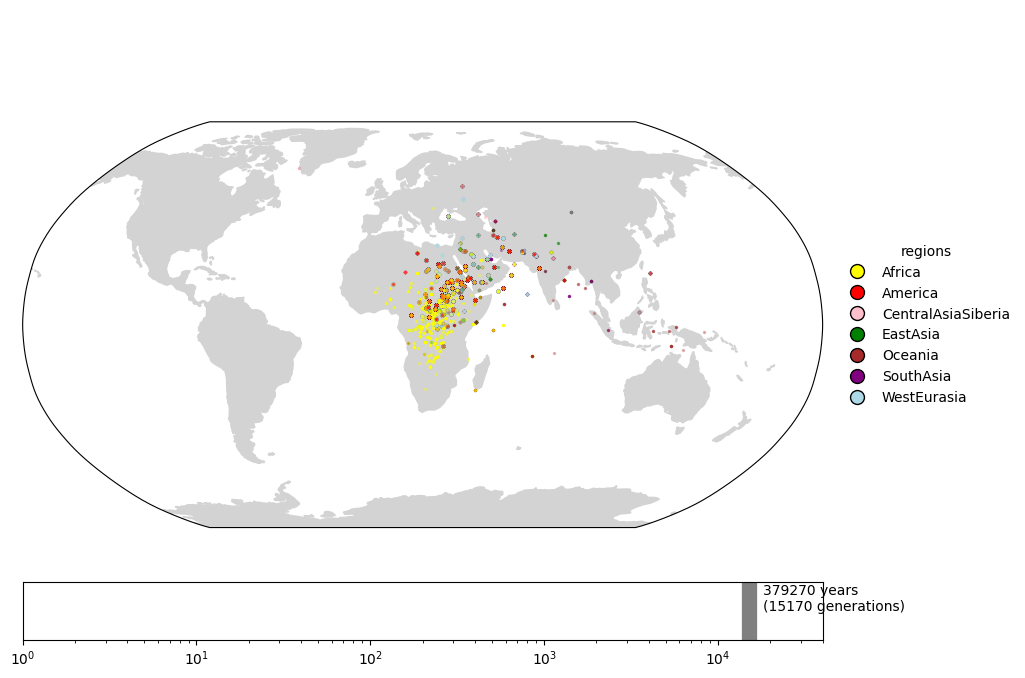

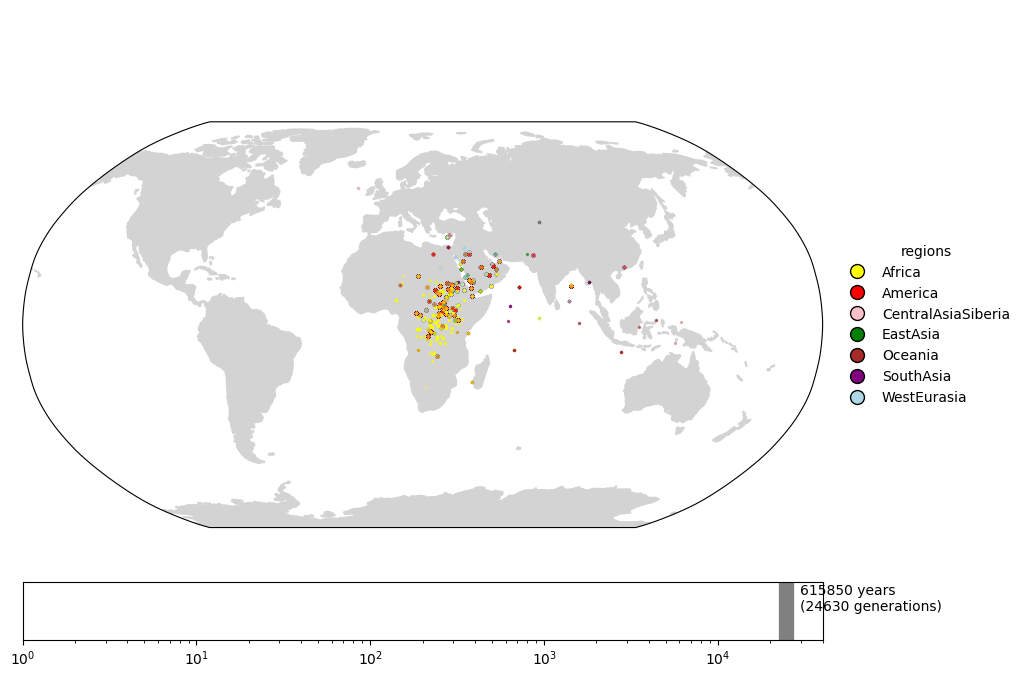

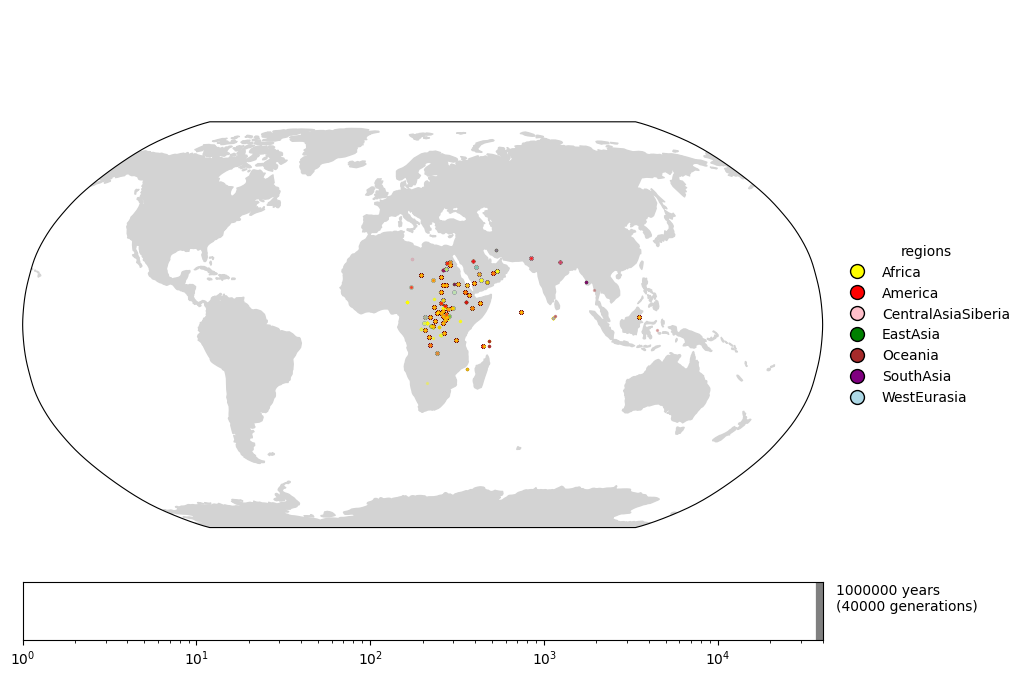

In [37]:
projection = ccrs.Robinson(central_longitude=20)
data_crs = ccrs.PlateCarree() #data supplied in lat/long

for time_ix in range(len(ancestor_times)):

    fig, axs = plt.subplots(2, 1, figsize=(10, 7), height_ratios=[1, 0.1])
    ax = axs[0]
    ax.axis("off")
    dummy = axs[1]
    dummy.set_yticks([])
    
    ax = plt.axes(projection=projection)
    ax.set_global()
    ax.add_feature(cfeature.LAND, color='lightgray')
    
    # plot all ancestors of each sample
    for sample in range(len(samples)): 
        locs = anc_locs[:,sample,time_ix,-2:]
        ax.scatter(locs[:, 0], locs[:, 1], color=group_colors[group_ixs[sample]], s=2, alpha=0.3, zorder=0, transform=data_crs)

    # legend
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=i, 
                markeredgecolor='k', markersize=10, linestyle='') for i in group_colors]
    ax.legend(handles, group_names, title="regions", loc='center right', bbox_to_anchor=(1.25, 0.5), frameon=False)

    # timeline
    vline = dummy.axvline(ancestor_times[time_ix] if ancestor_times[time_ix]>0 else 1, linewidth=11, color="grey")
    dummy.set_xlim(1, ancestor_times[len(ancestor_times)-1])
    dummy.set_xscale("log")
    dummy.text(
            ancestor_times[time_ix]*1.2 if ancestor_times[time_ix]>0 else 1.2,
            0.5,
            str(int(np.round(ancestor_times[time_ix] * 25, -1)))
            + " years \n"
            + "("
            + str(int(np.round(ancestor_times[time_ix], -1)))
            + " generations)",
        )

    plt.subplots_adjust(left=0, bottom=0.1, right=0.8, top=1, wspace=0, hspace=0)
    # plt.tight_layout()
    plt.savefig(plotdir + 'group_%d.png' %time_ix)
    plt.show()

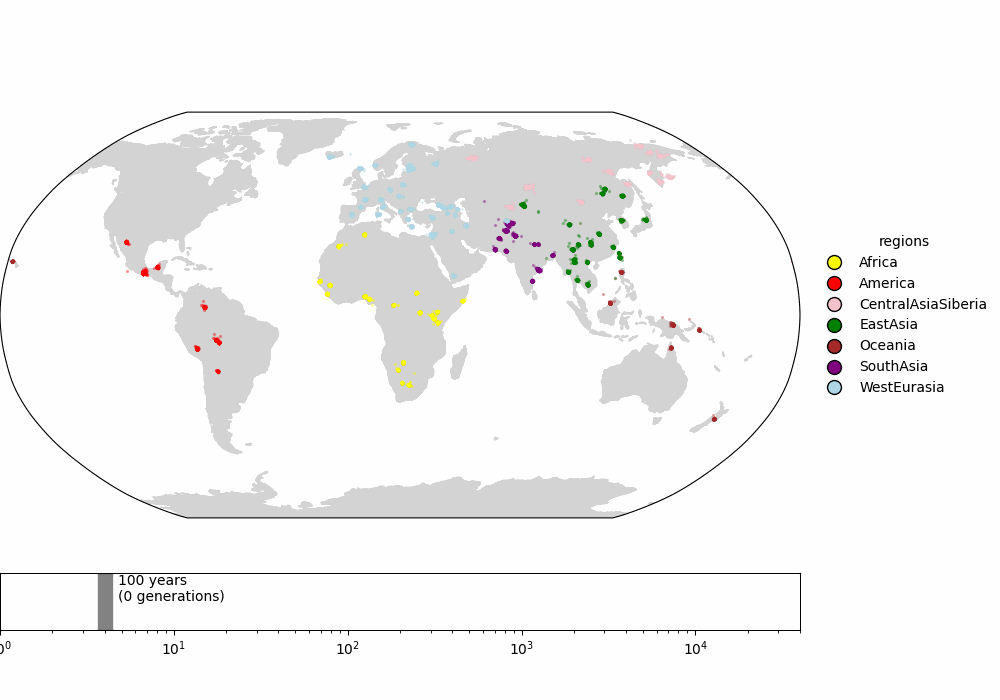

In [39]:
# make gif
frames = []
for time_ix in range(len(ancestor_times)-1):
    frames.append(imageio.v2.imread(plotdir + 'group_%d.png' %time_ix))
    
gifname = plotdir + 'group.gif'
imageio.mimsave(gifname, frames, duration=1000, loop=0)
display(Image(filename=gifname))